In [7]:
import re
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
from plotly.subplots import make_subplots
df = pd.read_csv("../../data/external/processed/all_hla.csv")
df["binder"] = df["measurement_value"].apply(lambda x: True if x < 500 else False)

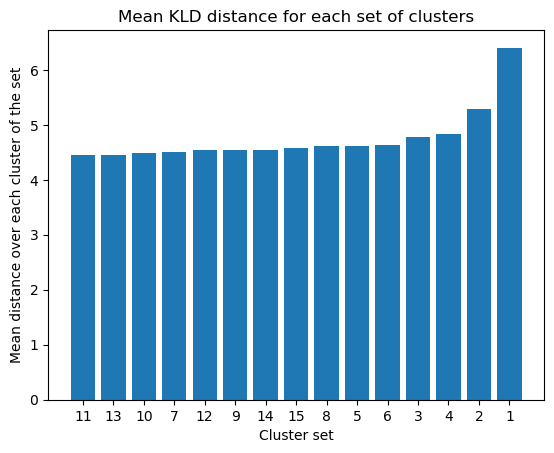

In [8]:
max_clusters = 15
clusters = range(1, max_clusters+1)
cluster_mean_kld = []
cluster_set_cluster_kld = []
for i in clusters:
    result_f = open(f"/home/daqop/mountpoint_snellius/softwares/gibbscluster-2.0/run/all_hla_peptides_clusters_1_15_with_trash_1876625/res/gibbs.{i}g.out")
    average_klds_lines = [line.replace("\n", "") for line in result_f if "Final KLD sum after" in line and "###" not in line]

    klds = []
    clusters_in_set = []
    for l in average_klds_lines:
        cluster = re.search("(?<=group\s)[0-9]*", l).group()
        kld = re.search("(?<=epochs\s-\s)[+-]?([0-9]*[.])?[0-9]*", l).group()
        klds.append(float(kld))
        clusters_in_set.append(str(cluster))
    cluster_set_cluster_kld.append(dict(zip(clusters_in_set, klds)))
    klds = np.array(klds)
    cluster_mean_kld.append(klds.mean())

#convert to np.array for sorting based on indices
cluster_mean_kld = np.array(cluster_mean_kld)
clusters = np.array(clusters)

# generate sorted indices and reorder arrays:
sorted_indices = np.argsort(cluster_mean_kld)
cluster_mean_kld = cluster_mean_kld[sorted_indices]
clusters = clusters[sorted_indices]

plt.bar([str(cluster) for cluster in clusters], height=cluster_mean_kld)
plt.title("Mean KLD distance for each set of clusters")
plt.xlabel("Cluster set")
plt.ylabel("Mean distance over each cluster of the set")
plt.savefig("../../reports/figures/gibbs_clusters/kld_mean_distances_flat_background.svg")


In [29]:
df_t = df.groupby(["cluster_set_3", "binder"], as_index=False).size()
df_t.loc[df_t["binder"]==False]["size"]

0    17546
2    15348
4    13403
Name: size, dtype: int64

In [9]:
# visualize a specific set of cluster mean 
titles_list = [
        [f"KLD distances for cluster set {i+1}", f"Binder/non binders distribution for cluster set {i+1}"]
        for i in range(15)
    ]
def flatten(l):
    return [item for sublist in l for item in sublist]

#number of peptides per cluster:
fig = make_subplots(
    rows=15,
    cols=2,
    start_cell="top-left",
    subplot_titles = flatten(titles_list)
)
fig.update_layout(
    height=3000,
    width=1600,
    title_text="KLD (left) and count (right) for each cluster set",
    showlegend=False,
)

for i in range(15):
    # First col:
    fig.add_trace(
        go.Bar(
            x=list(cluster_set_cluster_kld[i].keys()), 
            y=list(cluster_set_cluster_kld[i].values()),
            marker_color="blue"
            # title=f"KLD distance for each cluster in cluster set {i}",
            # labels = {
            #     "y": "KLD",
            #     "x": "cluster"
            # }
        ),
        row=i+1, col=1,
    )
    df_grouped_clusters = df.groupby([f"cluster_set_{i+1}", "binder"], as_index=False).size()

    # Second col (with stacked binders and non binders)
    fig.add_trace( # binders
        go.Bar(
            x=list(range(i+1)), 
            y=df_grouped_clusters.loc[df_grouped_clusters["binder"] == True]["size"],
            offsetgroup=0,
            marker_color="green"
        ),
        row=i+1, col=2
    )

    fig.add_trace( # non binders
        go.Bar(
            x=list(range(i+1)), 
            y=df_grouped_clusters.loc[df_grouped_clusters["binder"] == False]["size"],
            offsetgroup=0,
            base=df_grouped_clusters.loc[df_grouped_clusters["binder"] == True]["size"],
            marker_color="red"
        ),
        row=i+1, col=2
    )
fig.show()
fig.write_image("../../reports/figures/gibbs_clusters/cluster_sets_flat_background.svg")


In [ ]:
# visualize distribution of binders/non binders per cluster:
df_binders = df.groupby(["cluster", "binder"]).size().reset_index()

fig = px.bar(df_binders, x="cluster", y=0, color="binder", title="Frequency of binders per cluster")
fig.show()